In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import xarray as xr 

from src import utils, plots, cesm_utils
from src.inputs import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load observation data
prect_sources = ["GPCC", "CRUT", "APHR"]
sst_sources = ["ERSST", "HADISST", "COBESST"]

obs_msea_prect_anomalies = {source: utils.get_obs_msea_prect_anomaly_timeseries_mam(
    source) for source in prect_sources}
obs_nino34_sst_anomalies = {source: utils.get_obs_nino34_sst_anomaly_timeseries_djf(
    source) for source in sst_sources}
obs_global_sst_climatology = {key: utils.load_global_sst_data(
    path) for key, path in sst_reanalysis_source_to_file.items()}

obs_msea_prect_anomalies_list = [
    obs_msea_prect_anomalies["GPCC"],
    obs_msea_prect_anomalies["CRUT"],
    obs_msea_prect_anomalies["APHR"],
]

obs_nino34_sst_anomalies_list = [
    obs_nino34_sst_anomalies["ERSST"],
    obs_nino34_sst_anomalies["HADISST"],
    obs_nino34_sst_anomalies["COBESST"],
]

obs_global_sst_climatology_list = [
    obs_global_sst_climatology["ERSST"],
    obs_global_sst_climatology["HADISST"],
    obs_global_sst_climatology["COBESST"],
]

In [3]:
# Load CESM data
ensemble_members = models.CESM2_ensemble_members # List of CESM2 Ensemble Members

cesm_global_djf_sst_map = cesm_utils.process_cesm_ensemble(
    ensemble_members, 
    CESM2_LENS2_dir,
    "SST.global.1900_2100")  # annual global DJF ssts
    
cesm_msea_mam_prect_timeseries = cesm_utils.process_cesm_ensemble(
    ensemble_members,
    CESM2_LENS2_dir,
    "PRECT.MSEA")  # monthly MSEA ssts

# select same time period as observations for comparison
cesm_global_djf_sst_map = cesm_global_djf_sst_map['SST'].sel(time=slice('1951', '2015'))
cesm_msea_mam_prect_timeseries = cesm_msea_mam_prect_timeseries.sel(time=slice('1951', '2015'))

In [4]:
# CESM Regression: regress MSEA MAM index onto global DJF SSTs
regression_cesm = utils.regress_index_onto_field(cesm_global_djf_sst_map, cesm_msea_mam_prect_timeseries)
regression_cesm_mean = regression_cesm.mean(dim='ensemble')

# Regrid observed SSTs to CESM grid
obs_global_sst_climatology_list_regridded = utils.regrid_observed_ssts_to_cesm_grid(
    obs_global_sst_climatology_list, regression_cesm_mean
    )

# Observed Regression: regress MSEA MAM index onto (regridded) global DJF SSTs
regression_obs = utils.regress_index_list_onto_field_list(
    obs_global_sst_climatology_list_regridded, obs_msea_prect_anomalies_list)

In [5]:
titles = [
    "a) [ERSSTv5, GPCC]", 
    "b) [ERSSTv5, CRU TS4.06]", 
    "c) [ERSSTv5,  APHRODITE]",
    "d) [HadISSTv1.1, GPCC]", 
    "e) [HadISSTv1.1, CRU TS4.06]", 
    "f) [HadISSTv1.1, APHRODITE]",
    "g) [COBE-SST2, GPCC]", 
    "h) [COBE-SST2, CRU TS4.06]", 
    "i) [COBE-SST2, APHRODITE]"] 

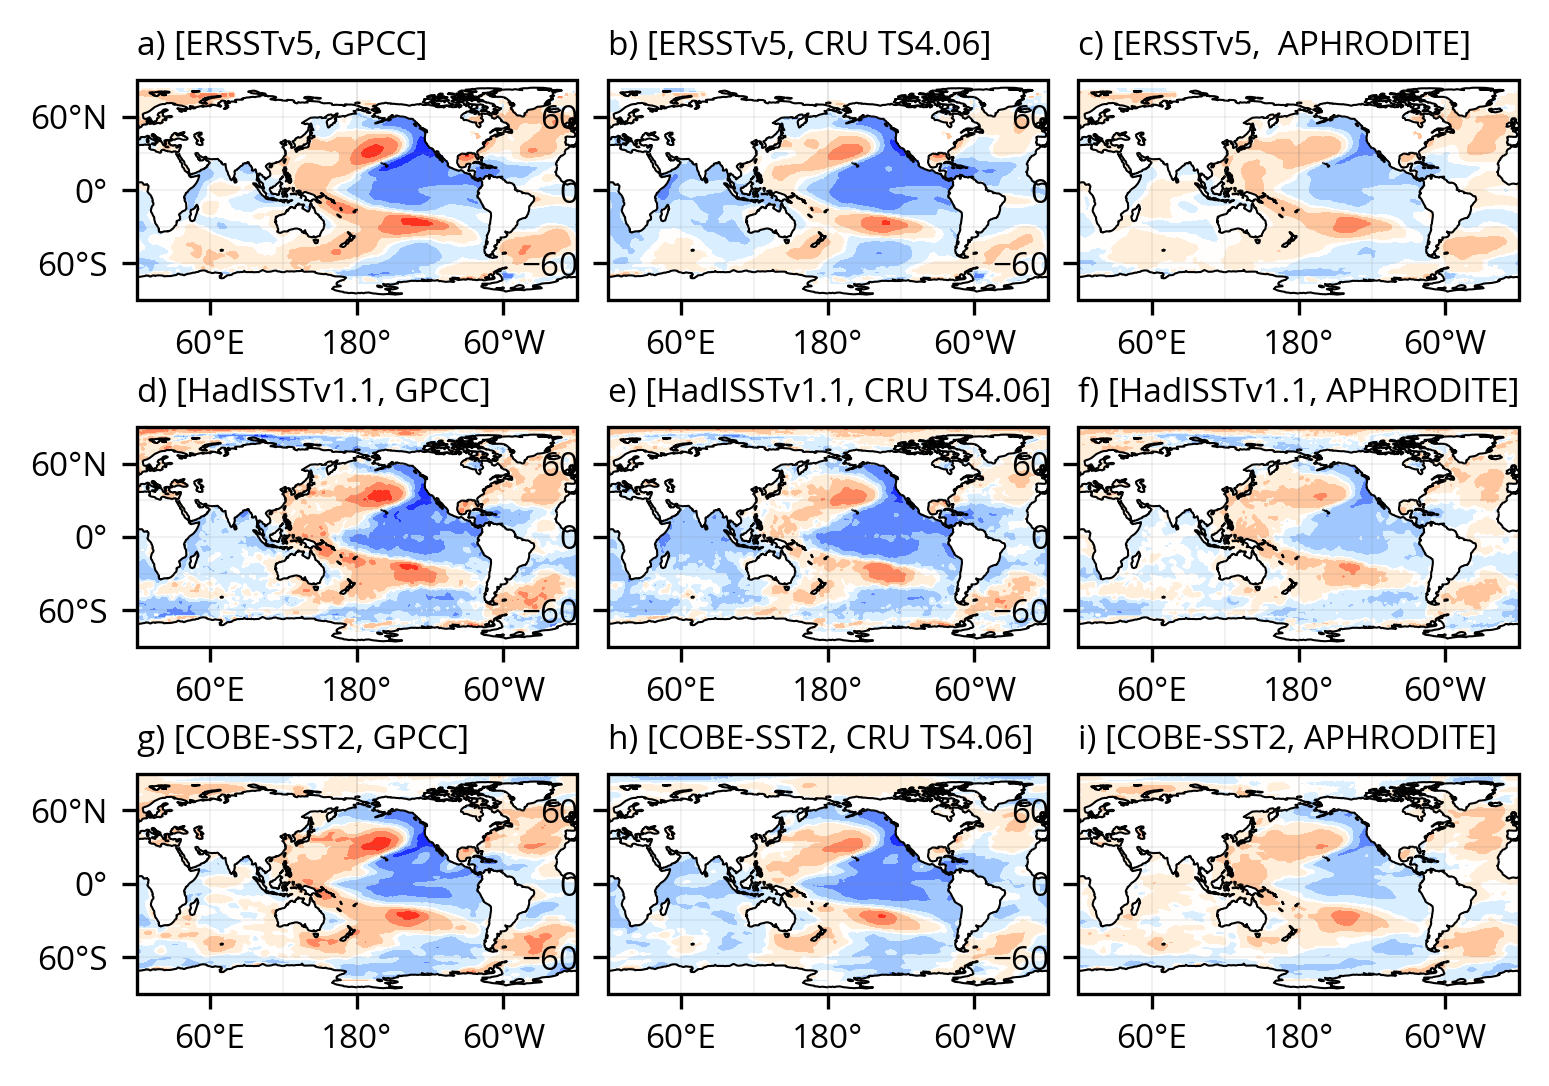

In [6]:

utils.set_matplotlib_font("Open Sans")
lat_formatter = LatitudeFormatter()
lon_formatter = LongitudeFormatter(zero_direction_label=True)

color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 13 
fig_height_cm = 9
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(3, 3, top=0.95, bottom=0.05, left=0.08, right=0.98, hspace = 0.32, wspace=0.07)
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[0, 2], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax5 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax6 = fig.add_subplot(gs1[1, 2], projection=ccrs.PlateCarree(central_longitude=180))
ax7 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax8 = fig.add_subplot(gs1[2, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax9 = fig.add_subplot(gs1[2, 2], projection=ccrs.PlateCarree(central_longitude=180))

axs = [
    ax1, ax2, ax3, 
    ax4, ax5, ax6,
    ax7, ax8, ax9]

for i, ax in enumerate(axs):
    plots.plot_regression_map(ax, regression_obs.isel(datasets=i))
    ax.set_title(titles[i], loc="left", fontsize=8)


axs = [ax1, ax4, ax7]
for i, ax in enumerate(axs):

    ax.set_yticks([-60, 0, 60], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-60, 0, 60], fontsize=8)

    ax.tick_params(axis='y', which='major', labelsize=8)  # Set tick params for each ax

    ax.yaxis.set_major_formatter(lat_formatter)

axs = [ax7, ax8, ax9]
for i, ax in enumerate(axs):

    ax.set_xticks([60, 180, 300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([60, 180, 300], fontsize=8)

    ax.xaxis.set_major_formatter(lon_formatter)


plt.savefig("FigS2.png")
plt.savefig("FigS2.pdf")



In [8]:
# Add CESM2 model mean regression coefficients
regression_concatenated = xr.concat([regression_obs, regression_cesm_mean], dim='datasets')

In [9]:
# Initialize a 9x9 matrix to store the correlation coefficients
correlation_matrix = np.zeros((10, 10))

# Calculate the correlation coefficients
for i in range(10):
    for j in range(10):
        if i == j:
            correlation_matrix[i, j] = 1  # Correlation with itself is 1
        else:
            correlation_matrix[i, j] = xr.corr(regression_concatenated.isel(datasets=i), regression_concatenated.isel(datasets=j)).item()

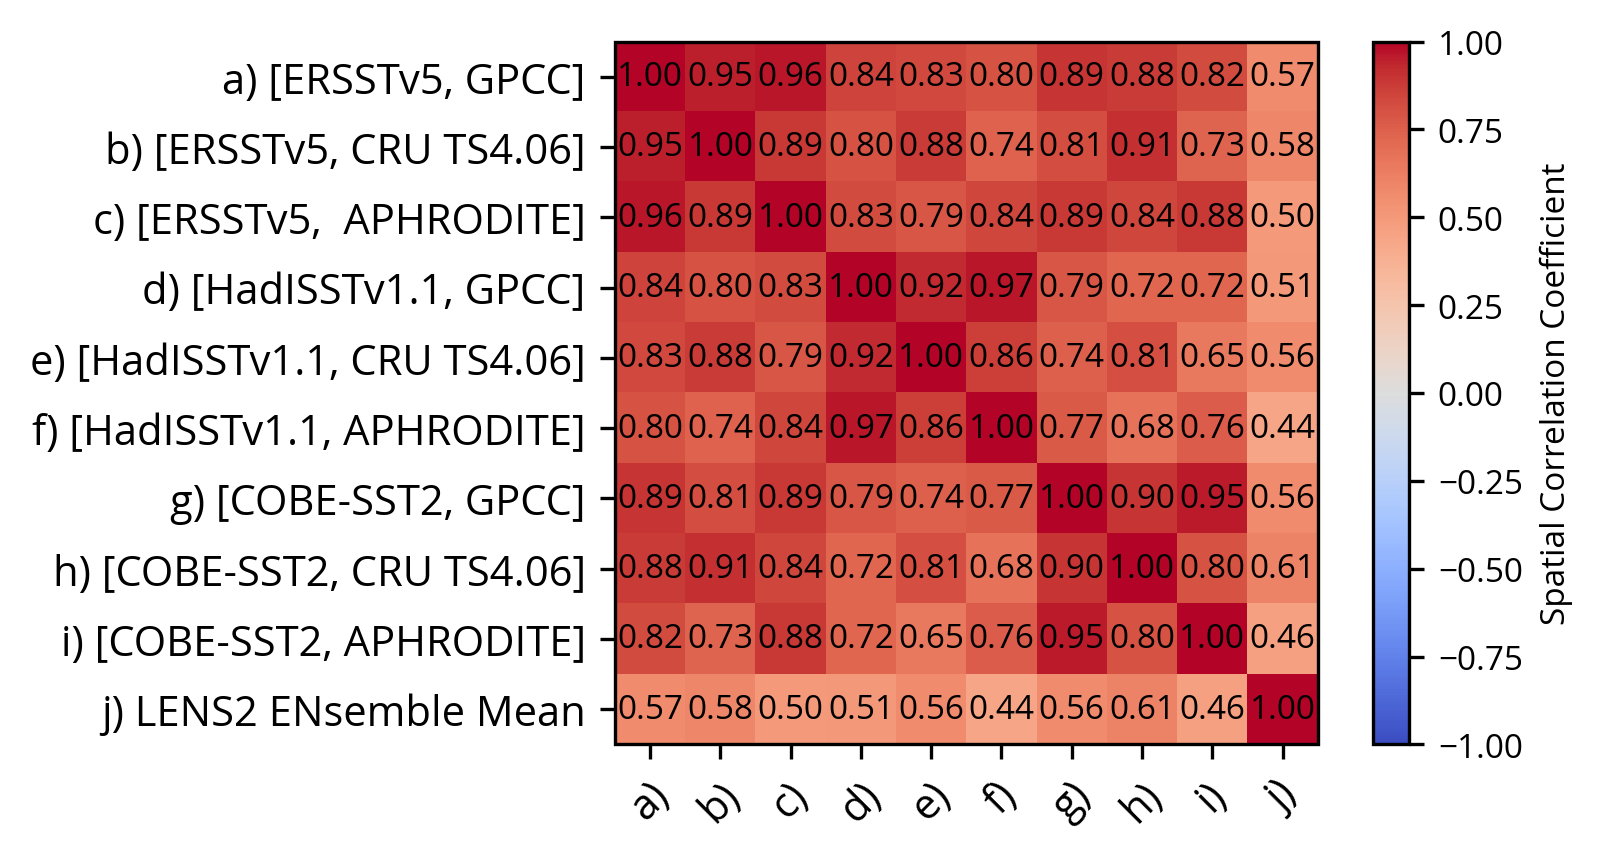

In [10]:
fig_width_cm = 13.5
fig_height_cm = 7
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)
gs1 = GridSpec(1,1, top=0.95, bottom=0.1, left=0.27, right=0.97, hspace = 0.32, wspace=0.07)
ax = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))

plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Spatial Correlation Coefficient',)

labels_y = [
    "a) [ERSSTv5, GPCC]", 
    "b) [ERSSTv5, CRU TS4.06]", 
    "c) [ERSSTv5,  APHRODITE]",
    "d) [HadISSTv1.1, GPCC]", 
    "e) [HadISSTv1.1, CRU TS4.06]", 
    "f) [HadISSTv1.1, APHRODITE]",
    "g) [COBE-SST2, GPCC]", 
    "h) [COBE-SST2, CRU TS4.06]", 
    "i) [COBE-SST2, APHRODITE]",
    "j) LENS2 ENsemble Mean"
]

labels_x = [
    "a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)",
]
plt.xticks(ticks=np.arange(10), labels=[labels_x[i] for i in range(10)], rotation=45, fontsize=10)
plt.yticks(ticks=np.arange(10), labels=[labels_y[i] for i in range(10)], fontsize=10)

# Annotate correlation coefficients
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

plt.savefig("FigS3.png")
plt.savefig("FigS3.pdf")